# Preprocesamiento de las secuencias genómicas SARS-CoV-2

### Instalación de Librerías

In [1]:
!pip install plotly

In [2]:
!pip install Bio

In [3]:
!pip install pygrok

In [4]:
!pip install -U scikit-learn scipy matplotlib

### Importación de librerias

In [90]:
import warnings
warnings.filterwarnings('ignore')
#Librería para el formato de fecha
from pygrok import Grok
#Librería bioinformática
from Bio import SeqIO, Seq
from Bio.SeqIO.FastaIO import FastaIterator
from Bio.Align import MultipleSeqAlignment
#Librerías para los datos
import numpy as np
import pandas as pd
from datetime import date
import operator
import collections
from collections import Counter, defaultdict
#Librería de preprocesamiento y reducción de dimensionalidad
from sklearn.preprocessing import StandardScaler,scale
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import MDS
#Librería de distancia
from scipy.spatial.distance import pdist, hamming, squareform
#Librerías para gráficos
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

### Lectura del archivo FASTA con todas las secuencias genómicas SARS-CoV-2

- Variables iniciales

In [92]:
grok = Grok('%{YEAR:year}-%{MONTHNUM:month}-%{MONTHDAY:day}')
lista = ['AMA','ANC','APU','ARE','AYA','CAJ','CUS','HUV','HUC','HVC','HUA','HCV','HUN','ICA','JUN','LAL','LAM','LIM','LOR','MDD','MOQ','PAS','PIU','PUN','SAM','SAN','TAC','TUM','UCA','CAL','C01','C02','C03']
diccionario = {'AMA' : 'Amazonas','ANC' : 'Áncash','APU' : 'Apurímac','ARE' : 'Arequipa',
               'AYA' : 'Ayacucho','CAJ' : 'Cajamarca','CUS' : 'Cusco',
               'HUV' : 'Huancavelica','HUC' : 'Huánuco',
               'HVC' : 'Huancavelica','HUA' : 'Huánuco',
               'HCV' : 'Huancavelica','HUN' : 'Huánuco',
               'ICA' : 'Ica','JUN' : 'Junín','LAL' : 'La Libertad',
               'LAM' : 'Lambayeque','LIM' : 'Lima','LOR' : 'Loreto','MDD' : 'Madre de Dios',
               'MOQ' : 'Moquegua','PAS' : 'Pasco','PIU' : 'Piura','PUN' : 'Puno',
               'SAM' : 'San Martín', 'SAN' : 'San Martín',
               'TAC' : 'Tacna','TUM' : 'Tumbes','UCA' : 'Ucayali',
               'CAL' : 'Callao', 'C01' : 'Callao', 'C02': 'Callao','C03': 'Callao'}

- Lectura de archivos

In [93]:
registros = list(SeqIO.parse("gisaid_hcov-19_2021_10_02_23.fasta", "fasta"))
df_info = pd.read_csv("gisaid_hcov-19_2021_10_03_00.tsv",sep='\t')
print("Cantidad de secuencias genómicas SARS-CoV-2 en el archivo .fasta:",len(registros))

Cantidad de secuencias genómicas SARS-CoV-2 en el archivo .fasta: 6520


### Obtención del código, la fecha de recolección y el lugar de donde se obtuvo cada secuencia genómica SARS-CoV-2

In [95]:
abrevPlaces=list() #Lista de las abreviaciones de los lugares
fechas=list() #Lista de las fechas
secuencias=list() #Lista de las secuencias
secuenciasEliminadas=list() #Lista de las secuencias eliminadas
for i in range(len(registros)):
    name=registros[i].id
    #Obtener la abreviación del nombre del departamento
    primer_indice=name.find('/')
    segundo_indice = name.find('/', primer_indice + 1)
    place=name[segundo_indice+1:segundo_indice+4]
    #Secuencias que no tienen un lugar definido
    if not place in lista:
        secuenciasEliminadas.append(registros[i])
        continue
    else:
        if not place in abrevPlaces:
            abrevPlaces.append(place)
        #Obtener el código de la secuencia
        primer_indice=name.find('|')
        segundo_indice = name.find('|', primer_indice + 1)
        codigo=name[primer_indice+1:segundo_indice]
        #Obtener la fecha de recolección
        valor=grok.match(name)
        if valor == None:
            secuenciasEliminadas.append(registros[i])
            continue
        else:
            fecha=valor['year'] + '-' + valor['month'] + '-' + valor['day']
            #Guardar los datos obtenidos
            registros[i].name=diccionario[place]
            registros[i].description=fecha   
            registros[i].id=codigo 
            fechas.append(fecha)
            #Guardar la secuencia
            secuencias.append(registros[i])
print("Cantidad de secuencias eliminadas:",len(secuenciasEliminadas))

Cantidad de secuencias eliminadas: 30


### Eliminación de las secuencias genómicas SARS-CoV-2 con errores de lectura

In [96]:
#Eliminamos las secuencias con errores de lectura en el archivo fasta (definido como letras distintas de A, C, G, T).
pos,cantSecEli=0,0
while pos<len(secuencias):
    registro=set(secuencias[pos].seq)
    if 'N' in registro or 'K' in registro or 'M' in registro or 'R' in registro or 'S' in registro or 'W' in registro or 'Y' in registro:
        secuencias.pop(pos)
        cantSecEli+=1
    else:
        pos+=1
print("Cantidad de secuencias eliminadas:",cantSecEli)
print("Cantidad de secuencias a preprocesar:",len(secuencias))

Cantidad de secuencias eliminadas: 5125
Cantidad de secuencias a preprocesar: 1365


### Obtención del linaje pango de las secuencias genómicas SARS-CoV-2 a procesar

In [97]:
df = pd.DataFrame(columns=['id', 'secuencia', 'secuenciaAlineada','lugar','fecha','linaje','variante','color'])
for secu in secuencias:
    df = df.append({'id': secu.id, 'secuencia':secu.seq, 'lugar':secu.name,'fecha':secu.description}, ignore_index=True)
ids = np.array(df['id'])
ids = ids.astype('str')
cant=[]
for i in range(len(df_info)):
    id=df_info.iloc[i]['Accession ID']
    variante=df_info.iloc[i]['Lineage']
    indice=np.where(ids == id)
    if len(indice[0]) == 1:
        df['linaje'][indice[0][0]]=variante
    else:
        #secuencias eliminadas
        cant=np.append(cant,[id],axis= 0)

### Alineamiento múltiple de las secuencias genómicas SARS-CoV-2

In [99]:
maxlongitud = max(len(registro.seq) for registro in secuencias)
i=0
for registro in secuencias:
    if len(registro.seq) != maxlongitud:
        secuencia = str(registro.seq).ljust(maxlongitud, '.')
        registro.seq = Seq.Seq(secuencia)
    df['secuenciaAlineada'][i]=registro.seq
    i=i+1
secuenciasAlineadas = MultipleSeqAlignment(secuencias)
print(secuenciasAlineadas)

Alignment with 1365 rows and 29904 columns
TTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTG...... EPI_ISL_415787
CAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCA...... EPI_ISL_482468
GGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTT...... EPI_ISL_487269
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489836
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489837
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489838
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489839
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489987
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489988
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489989
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_489990
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_490209
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_490315
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...... EPI_ISL_490316
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTC

### Calculo de la matriz de distancia Hamming

- Convertir las secuencias genómicas SARS-CoV-2 a una matriz

In [120]:
matriz_secuencias= np.array([ list(secuencia.seq) for secuencia in secuenciasAlineadas])
matriz_secuencias

array([['T', 'T', 'A', ..., '.', '.', '.'],
       ['C', 'A', 'G', ..., '.', '.', '.'],
       ['G', 'G', 'A', ..., '.', '.', '.'],
       ...,
       ['A', 'C', 'C', ..., '.', '.', '.'],
       ['A', 'C', 'C', ..., '.', '.', '.'],
       ['A', 'C', 'C', ..., '.', '.', '.']], dtype='<U1')

- Función para calcular la distancia Hamming

In [121]:
def ham(seq1,seq2):
    return hamming(seq1,seq2)

- Calcular una matriz de distancia condensada

In [122]:
distancia_condensada=pdist(matriz_secuencias, ham)
dist_condensada=np.around(np.array(distancia_condensada),2)

- Convertir la matriz de distancia condensada a matriz de distancia completa

In [123]:
matriz_distancias=squareform(dist_condensada)

- Realizar el histograma para ver cual es la mayor distancia encontrada

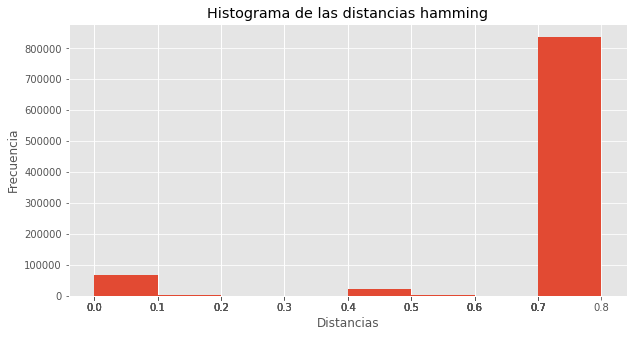

In [106]:
bins=np.around(np.unique(dist_condensada),1)
plt.figure(figsize=(10,5))
plt.hist(x=dist_condensada, bins=bins)
plt.title('Histograma de las distancias hamming')
plt.xlabel('Distancias')
plt.ylabel('Frecuencia')
plt.xticks(bins)
plt.show()

### Realizar el escalamiento multidimensional (MDS)

In [45]:
componentes=[2, 100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500]
stress=list()
for i in componentes:
    mds = MDS(n_components=i, max_iter=300, eps=1e-12,
                    dissimilarity="precomputed", random_state=0, n_jobs=-1,
                    n_init=10)
    matriz_mds=mds.fit_transform(matriz_distancias)
    stress.append(mds.stress_)

- Se realiza el gráfico para ver el valor del stress con relación al número de componentes

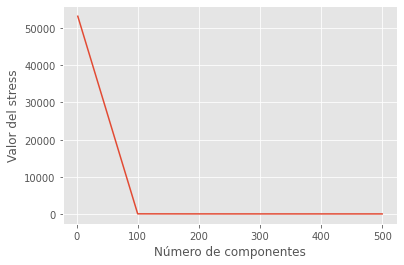

In [46]:
plt.plot(componentes, stress)
plt.xlabel('Número de componentes')
plt.ylabel('Valor del stress')
plt.show()

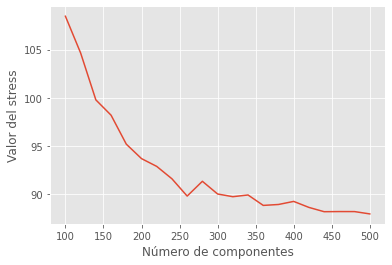

In [47]:
plt.plot(componentes[1:], stress[1:])
plt.xlabel('Número de componentes')
plt.ylabel('Valor del stress')
plt.show()

- Elección de una menor dimensión

In [81]:
#Se obtiene el componente con el menor valor de stress
#Se puede tolerar el 95% con respecto al mínimo valor de estrés
valor=min(stress)*1.05
dist=10000
estres=0
for i in stress:
    distP=valor - i
    if distP > 0 and distP < dist:
        dist=distP
        estres=i
index = stress.index(estres)
component=componentes[index]

- Se vuelve a realizar MDS pero aumentando la cantidad máxima de iteraciones (max_iter) y el número de veces que se va a ejecutar el algoritmo SMACOF (n_init)

In [124]:
mds = MDS(n_components=component, max_iter=500, eps=1e-12,
                    dissimilarity="precomputed", random_state=0, n_jobs=-1,
                    n_init=15)
matriz_mds=mds.fit_transform(matriz_distancias)
print("Coordenadas de las secuencias genómicas SARS-CoV-2")
matriz_mds

Coordenadas de las secuencias genómicas SARS-CoV-2


array([[-0.00436889,  0.02013774,  0.02168775, ..., -0.01945805,
         0.04018877,  0.01432612],
       [ 0.04982756, -0.01499754, -0.0333079 , ...,  0.04998861,
         0.00224913,  0.00288901],
       [ 0.00120141, -0.05872979, -0.02770927, ..., -0.01698265,
         0.00101824,  0.07168888],
       ...,
       [ 0.02545713,  0.01387278,  0.02134927, ..., -0.01573194,
        -0.00279473,  0.00118107],
       [ 0.02547406,  0.01381825,  0.02137959, ..., -0.01571638,
        -0.00276684,  0.00121269],
       [ 0.02108069,  0.01909477,  0.03006882, ...,  0.00216565,
         0.00847478,  0.02850551]])

### Realizar el análisis de componentes principales (PCA)

Tamaño de X_pca (1365, 240)


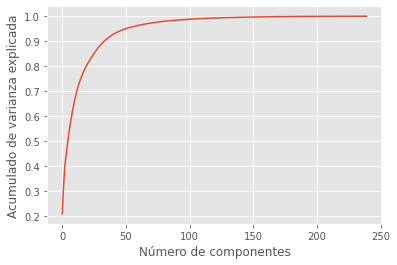

In [126]:
pca=PCA(n_components=component) 
pca.fit(matriz_mds)
X_pca=pca.transform(matriz_mds) 
print("Tamaño de X_pca", X_pca.shape)
#Grafica del acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Acumulado de varianza explicada')
plt.show()

In [127]:
valor=np.cumsum(pca.explained_variance_ratio_[:2])[1]*100
print("Porcentaje de varianza explicada con los dos primeros componentes principales: ",round(valor, 2),"%")

Porcentaje de varianza explicada con los dos primeros componentes principales:  31.83 %


In [128]:
print("Componentes principales")
X_pca

Componentes principales


array([[-1.18358173e-01, -5.86122495e-02, -5.26868056e-02, ...,
        -3.31998525e-03,  8.92567867e-04,  5.43324174e-03],
       [-5.84806516e-02,  1.86980620e-03, -4.86888075e-02, ...,
         4.92435483e-04,  2.18843512e-04, -9.53898725e-04],
       [-6.01976062e-02, -2.20129019e-04, -5.04629274e-02, ...,
        -1.30131886e-03,  1.33634667e-03, -7.54514756e-04],
       ...,
       [-1.70577230e-01, -2.48758207e-01,  2.40159758e-01, ...,
         1.24011467e-05, -1.22431797e-04, -9.99256406e-05],
       [-1.70567286e-01, -2.48733999e-01,  2.40158227e-01, ...,
         1.38943704e-05, -1.19150541e-04, -9.89168004e-05],
       [-1.84972154e-01, -2.85304008e-01,  2.95485482e-01, ...,
         6.15012992e-04,  1.97239344e-03,  4.42334823e-03]])